In [29]:
from music21 import *
import matplotlib.pyplot as plt
import pickle
import pygame as pg
import time

In [3]:
from music21 import environment
import music21

In [4]:
us = environment.UserSettings()
us.getSettingsPath()

WindowsPath('C:/Users/ejian/AppData/Roaming/music21-settings.xml')

In [5]:
environment.set('musescoreDirectPNGPath', "C:/Program Files/MuseScore 3/bin/MuseScore3.exe")

In [6]:
def distinctFreqs(freq1:float, freq2:float, a=1.059):
    larger_freq = max(freq1, freq2)
    smaller_freq = min(freq1, freq2)
    if smaller_freq == 0:
        smaller_freq = 1e-100
    if larger_freq/smaller_freq >= a:
        return True
    else:
        return False
    
def eliminate(freqs:list):
    #returns a list of distinct freqs which are averaged
    i = len(freqs)-1
    while i > 0:
#         print(distinctFreqs(freqs[i-1], freqs[i]))
        if not(distinctFreqs(freqs[i-1], freqs[i])):
            avg = (freqs[i-1]+freqs[i])/2
            freqs.remove(freqs[i])
            freqs[i-1] = avg #gives more weight to higher freqs
        i-=1
        
    return freqs
    

In [7]:
freqs = [1234, 1235, 1236, 5678] 

freqs = eliminate(freqs)
print(freqs)

[1234.75, 5678]


In [8]:
def convert(freqTimes: dict):
    #returns a list of lists [freq, start, last seen instance, duration]
    freqDurations = []
    
    # key and value for the original dictionary
    for time, freqs in freqTimes.items():
        
        # each frequency in this current key of the dictionary
        for f in freqs: 
            
            #GOING THROUGH THE PREVIOUS LAYER
            # the default index of the current list item is the very last index (assuming it appends one)
            currentListIndex = len(freqDurations)
#             print("currListIndex at first= " + str(currentListIndex))
            
            # each index of the durations list
            previouslyFound = False
            for fd in range(0, len(freqDurations)):
                fd_item = freqDurations[fd]
                
                # if time is 0, will always return false
                if not distinctFreqs(fd_item[0], f) and fd_item[2] == time-1:
#                     print(fd_item[0], f)
                    currentListIndex = fd
#                     print("found in previous layer")
                    previouslyFound = True
                
                # current list item is the index of this newly added item
            if not previouslyFound:
                freqDurations.append([f, time, time, 1])
                    
            if (len(freqDurations) == 0):
                freqDurations.append([f, time, time, 1])
            
#             print("before: ")
#             print(freqDurations)
                    
            #GOING THROUGH THE NEXT LAYER
            # each frequency in the next key of the dictionary
            if (time + 1) < len(freqTimes):
                for next_freq in freqTimes[time+1]:
                    if not(distinctFreqs(f, next_freq)):
#                         print("not distinct: " + str(f) + "  " + str(next_freq))
                        avg = (f + next_freq)/2
                        # updates the frequency, changes the last seen instance, and adds 1 to the duration
#                         print("currListIndex= " + str(currentListIndex))
                        freqDurations[currentListIndex] = [avg, freqDurations[currentListIndex][1], 
                                                          time, freqDurations[currentListIndex][3] + 1]
                        #print(freqDurations[currentListIndex])
#             print("after: ")
#             print(freqDurations)
#             print()
#     print(freqDurations)            
    return freqDurations

In [9]:
big_arr_freqs = {0: [1234, 1235, 1236, 5678],
                1: [1234, 1235, 1236, 5678],
                2: [1237],
                3: [1230, 1240, 5000, 5670],
                4: [1000, 5678]}

#big_arr_freqs = {0: [1234, 1235, 1236, 5678],
#                1: [1234, 1235, 1236, 5678]}

for index in range(0, len(big_arr_freqs)):
        big_arr_freqs[index] = eliminate(big_arr_freqs[index]) 
        
#print(big_arr_freqs)

In [10]:
#what it should look like
"""
[1234.75, 0, 0, 2]
[5678.0, 0, 0, 3]
[1235.875, 1, 1, 2]
[1236.0, 2, 2, 2]
[5674.0, 3, 3, 2]
"""

freqDurs = convert(big_arr_freqs)
print(freqDurs)

[[1236.0, 0, 2, 4], [5678.0, 0, 0, 2], [5000, 3, 3, 1], [5674.0, 3, 3, 2], [1000, 4, 4, 1]]


In [11]:
from sklearn.cluster import KMeans
import numpy as np

def groupDuration(freqDurations: list, num_clusters: int, max_duration_num = 5):
    #returns list of cluster ids
    
    data = np.array([item[3] for item in freqDurations]).reshape(-1,1)
    kmeans = KMeans(num_clusters)
    kmeans.fit(data)
    
    clusters = kmeans.fit_predict(data)
    print(clusters)
    
    wcss=[]
    for i in range(1,max_duration_num):
        kmeans = KMeans(i)
        kmeans.fit(data)
        wcss_iter = kmeans.inertia_
        wcss.append(wcss_iter)

    number_clusters = range(1, max_duration_num)
    plt.plot(number_clusters,wcss)
    plt.title('The Elbow title')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    
    return clusters, num_clusters

    

C:\Users\ejian\anaconda3\envs\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ejian\anaconda3\envs\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ejian\anaconda3\envs\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ejian\anaconda3\envs\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMe

[1 2 0 2 0]


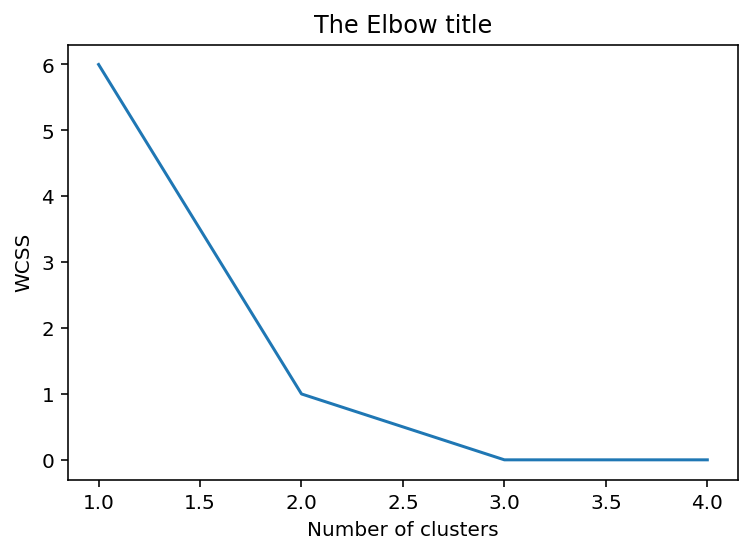

In [12]:
clusterIDs, num_clusters = groupDuration(freqDurs, num_clusters = 3, max_duration_num = 5)

In [13]:
# i don't know what i was thinking here, pls ignore
# def cluster_range(freqDurations: list, cluster_ids: list):
#     #returns dictionary of lists [start of freq range, end of freq range]
    
#     range_dict = {}
#     for index in range(0, len(cluster_ids)):
#         currID = cluster_ids[index]
#         currFreq = freqDurations[index][0]
        
#         # if it needs to be added to the range_list
#         if currID not in range_dict:
#             range_dict[currID] = [currFreq, currFreq]
        
#         # if already in the range_list
#         else:
            
#             # change the min if necessary
#             if currFreq < range_dict[currID][0]:
#                 range_dict[currID][0] = currFreq
                
#             # change the max if necessary
#             if currFreq > range_dict[currID][1]:
#                 range_dict[currID][1] = currFreq
                
#     return range_dict

In [14]:
# cluster_range(freqDurs, clusterIDs)

In [15]:
def durations(num_clusters: int):
    #returns list of durations
    quarter_index = int(num_clusters/2) 
    
    durationMappingKey = [0.166, 0.5, 1, 2, 4]
    
    duration_list = []
    start = 2 - quarter_index
    for i in range(start, start + num_clusters):
        duration_list.append(durationMappingKey[i])
        
    return duration_list


In [16]:
duration_list = durations(3)

In [17]:
print([freq[0] for freq in freqDurs])

[1236.0, 5678.0, 5000, 5674.0, 1000]


In [18]:
def notes(freqDurations: list, clusterIDs: list, duration_list: list):
    #return list of notes
    #normFreqs = music21.audioSearch.detectPitchFrequencies([freq[0] for freq in freqDurs])
    notes = []
    for freqIndex in range(len(freqDurations)):
        p = pitch.Pitch()
        p.frequency = freqDurations[freqIndex][0]
        n = note.Note(pitchName = p.name)
        d = duration.Duration()
        d.quarterLength = duration_list[clusterIDs[freqIndex]]
        n.duration = d
        notes.append(n)
    #print(normFreqs)
    return notes

In [19]:
notesList = notes(freqDurs, clusterIDs, duration_list)
#print(notesList)


In [20]:
notesDuration = [n.duration for n in notesList]
#print(notesDuration)

In [32]:
def streamNotes(notes: list):
    s = stream.Stream()
    for n in notes:
        s.append(n)
#     mf = midi.translate.streamToMidiFile(s)
    s.show()
    sp = midi.realtime.StreamPlayer(s, playForMilliseconds = 5000)
    sp.play()
#     return mf

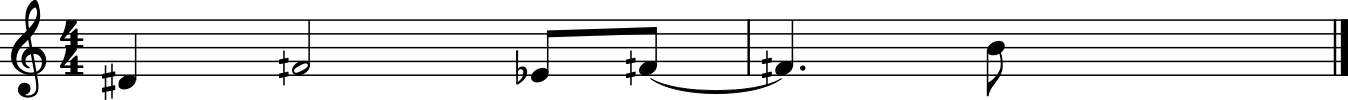

In [22]:
#streamNotes(notesList)

In [23]:
def sheetMusic(peak_dict: dict, num_clusters: int):
    for index in range(0, len(peak_dict)):
        peak_dict[index] = eliminate(peak_dict[index]) 
        
    freqDurs = convert(peak_dict)
    
    clusterIDs, num_clusters = groupDuration(freqDurs, num_clusters = num_clusters, max_duration_num = 5)
    
    duration_list = durations(num_clusters)
    
    notesList = notes(freqDurs, clusterIDs, duration_list)
    print(notesList)
    streamNotes(notesList)
    


In [24]:
def loadPeaks():
    with open("peaks.pkl", mode="rb") as opened_file:
        return pickle.load(opened_file)

In [25]:
peak_dict = loadPeaks()

In [26]:
for i in peak_dict.values():
    for f in i:
        if 0 == f:
            print('0')

In [27]:
print(peak_dict)

{0: [1, 24, 49, 73, 97, 122, 171, 222, 273, 324, 351, 405, 478, 522, 726, 765, 1240, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048], 1: [147, 1552, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048], 2: [196, 247, 298, 935, 1477, 1817, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048], 3: [863, 1273, 1392, 1529, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048], 4: [891, 1007, 1326, 1735, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048], 5: [840, 1096, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048], 6: [573, 985, 1

C:\Users\ejian\anaconda3\envs\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ejian\anaconda3\envs\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ejian\anaconda3\envs\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ejian\anaconda3\envs\week1\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMe

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]


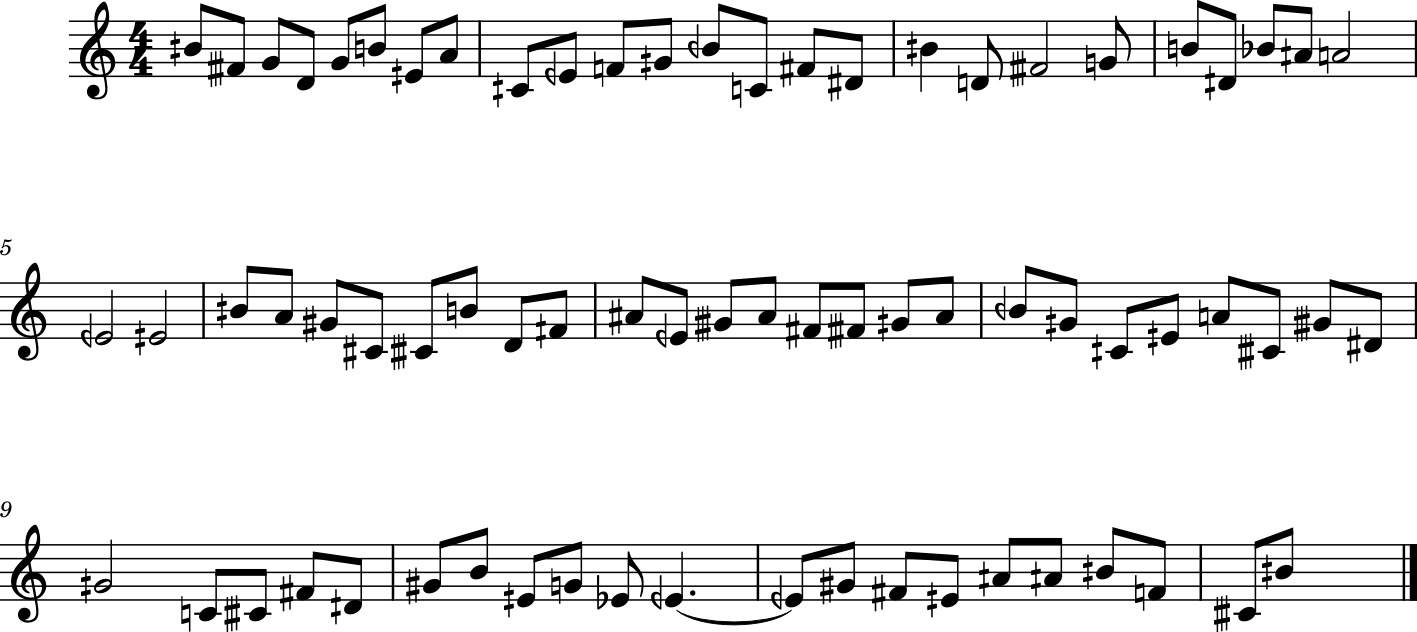

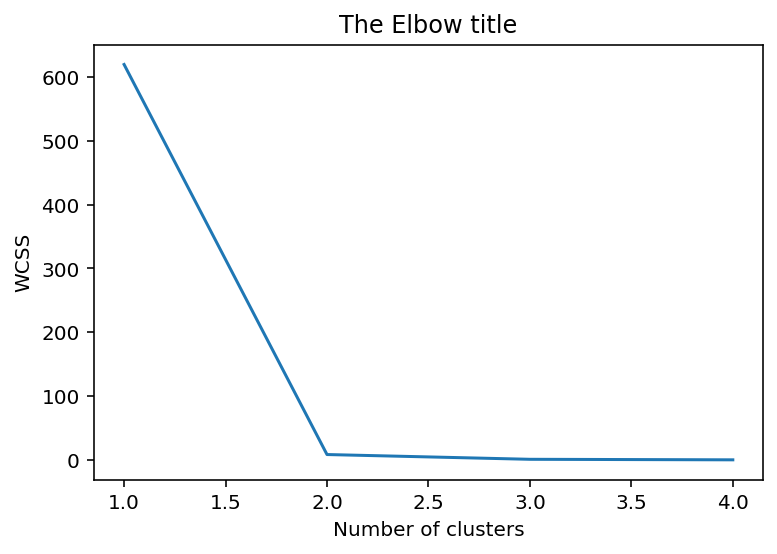

In [33]:
sheetMusic(peak_dict, num_clusters = 3)

In [ ]:
sp.stop()